In [1]:
import os

# Data Manipulation
import pandas as pd
import numpy as np
from pandas.io.stata import StataReader

# Visualization
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# Statistics
from scipy import stats
import statsmodels.formula.api as sm


# Profiling
import ydata_profiling as yp

# para a análise de dados espaciais
import geopandas as gp
import pysal as ps
import splot
import mapclassify as mc
# from libpysal.weights import Queen
# from libpysal import weights
# from esda import Moran, Moran_Local, G_Local
# from splot.esda import plot_moran, moran_scatterplot, lisa_cluster, plot_local_autocorrelation

# 1. Reading the data

In [2]:
# Read the file and the labels
with StataReader('../../dados/microdados-processados/amostra_domicilios_2010_RJ.dta') as reader:
    data_micro = reader.read(convert_categoricals=False)
    col_labels = reader.variable_labels()
    value_labels = reader.value_labels()

# Remove '_lbl' from the keys in value_labels
value_labels = {k.replace('_lbl', ''): v for k, v in value_labels.items()}

# Apply the labels to the data
for col, labels in value_labels.items():
    if col in data_micro:
        data_micro[col] = data_micro[col].map(labels)

# Apply the labels to the columns
data_micro = data_micro.rename(columns=col_labels)

# Convert ÁREA DE PONDERAÇÃO to int64
data_micro['ÁREA DE PONDERAÇÃO'] = data_micro['ÁREA DE PONDERAÇÃO'].astype('int64')
# Transform the column to string, remove the 8th character and convert back to int64
# This is done to make the column joinable with CD_GEOCODB from the SHP data
data_micro['ÁREA DE PONDERAÇÃO'] = data_micro['ÁREA DE PONDERAÇÃO'].astype(str).apply(lambda x: x[:7] + x[8:]).astype('int64')


filtra apenas os dados da Região Metropolitana do Rio de Janeiro

In [3]:
# df_rio = data_micro[data_micro['CÓDIGO DA MESORREGIÃO'] == 'Metropolitana do Rio de Janeiro']
df_rio = data_micro
df_rio.info()
df_rio.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 370244 entries, 0 to 370243
Data columns (total 76 columns):
 #   Column                                                                            Non-Null Count   Dtype  
---  ------                                                                            --------------   -----  
 0   UNIDADE DA FEDERAÇÃO                                                              370244 non-null  object 
 1   CÓDIGO DO MUNICÍPIO                                                               370244 non-null  object 
 2   ÁREA DE PONDERAÇÃO                                                                370244 non-null  int64  
 3   CONTROLE                                                                          370244 non-null  float64
 4   PESO AMOSTRAL                                                                     370244 non-null  float64
 5   REGIÃO GEOGRÁFICA                                                                 370244 non-null  o

,UNIDADE DA FEDERAÇÃO,CÓDIGO DO MUNICÍPIO,ÁREA DE PONDERAÇÃO,CONTROLE,PESO AMOSTRAL,REGIÃO GEOGRÁFICA,CÓDIGO DA MESORREGIÃO,CÓDIGO DA MICRORREGIÃO,CÓDIGO DA REGIÃO METROPOLITANA,SITUAÇÃO DO DOMICÍLIO,...,MARCA DE IMPUTAÇÃO NA V0218,MARCA DE IMPUTAÇÃO NA V0219,MARCA DE IMPUTAÇÃO NA V0220,MARCA DE IMPUTAÇÃO NA V0221,MARCA DE IMPUTAÇÃO NA V0222,MARCA DE IMPUTAÇÃO NA V0301,MARCA DE IMPUTAÇÃO NA V0401,MARCA DE IMPUTAÇÃO NA V0402,MARCA DE IMPUTAÇÃO NA V0701,Situação do setor
0,Rio de Janeiro,Angra dos Reis,330010003001,12833.0,1.072009e+14,Região sudeste (uf=31 a 33 e 35),Sul Fluminense,Baía da Ilha Grande,0,Urbana,...,Não,Não,Não,Não,Não,Não,Não,Não,Não,Área urbanizada
1,Rio de Janeiro,Angra dos Reis,330010003001,20358.0,1.901061e+14,Região sudeste (uf=31 a 33 e 35),Sul Fluminense,Baía da Ilha Grande,0,Rural,...,Não,Não,Não,Não,Não,Não,Não,Não,Não,Área rural de extensão urbana
2,Rio de Janeiro,Angra dos Reis,330010003001,27895.0,8.929838e+13,Região sudeste (uf=31 a 33 e 35),Sul Fluminense,Baía da Ilha Grande,0,Urbana,...,Não,Não,Não,Não,Não,Não,Não,Não,Não,Área urbanizada
3,Rio de Janeiro,Angra dos Reis,330010003001,42944.0,1.405041e+14,Região sudeste (uf=31 a 33 e 35),Sul Fluminense,Baía da Ilha Grande,0,Urbana,...,Não,Não,Não,Não,Não,Não,Não,Não,Não,Área urbanizada
4,Rio de Janeiro,Angra dos Reis,330010003001,52534.0,1.233563e+14,Região sudeste (uf=31 a 33 e 35),Sul Fluminense,Baía da Ilha Grande,0,Urbana,...,Não,Não,Não,Não,Não,Não,Não,Não,Não,Área urbanizada


# 2. Importando SHP

In [4]:
gdf = gp.read_file('shp/rj_setores_censitarios/33SEE250GC_SIR.shp')
gdf_rio = gdf[gdf['NM_MUNICIP'].isin(df_rio['CÓDIGO DO MUNICÍPIO'].str.upper().unique())]
gdf_rio.head()

,ID,CD_GEOCODI,TIPO,CD_GEOCODB,NM_BAIRRO,CD_GEOCODS,NM_SUBDIST,CD_GEOCODD,NM_DISTRIT,CD_GEOCODM,NM_MUNICIP,NM_MICRO,NM_MESO,geometry
0,43773,330025805000046,URBANO,None,None,33002580500,None,330025805,ARRAIAL DO CABO,3300258,ARRAIAL DO CABO,LAGOS,BAIXADAS,"POLYGON ((-42.01954 -22.96936, -42.02059 -22.9..."
1,43774,330025805000047,URBANO,None,None,33002580500,None,330025805,ARRAIAL DO CABO,3300258,ARRAIAL DO CABO,LAGOS,BAIXADAS,"POLYGON ((-42.02282 -22.96769, -42.02290 -22.9..."
2,43775,330025805000048,URBANO,None,None,33002580500,None,330025805,ARRAIAL DO CABO,3300258,ARRAIAL DO CABO,LAGOS,BAIXADAS,"POLYGON ((-42.16022 -22.94740, -42.16241 -22.9..."
3,43776,330025805000049,URBANO,None,None,33002580500,None,330025805,ARRAIAL DO CABO,3300258,ARRAIAL DO CABO,LAGOS,BAIXADAS,"POLYGON ((-42.17397 -22.94625, -42.17588 -22.9..."
4,43777,330025805000050,URBANO,None,None,33002580500,None,330025805,ARRAIAL DO CABO,3300258,ARRAIAL DO CABO,LAGOS,BAIXADAS,"POLYGON ((-42.17588 -22.94609, -42.17848 -22.9..."


In [5]:
# Read the shapefile
gdf = gp.read_file('shp/rj_setores_censitarios/33SEE250GC_SIR.shp')

# Filter the data to only the city of Rio de Janeiro
gdf_rio = gdf[gdf['NM_MUNICIP'].isin(df_rio['CÓDIGO DO MUNICÍPIO'].str.upper().unique())]

# Select the column with the code of the area and the geometry
selected_columns = ['CD_GEOCODB', 'NM_BAIRRO', 'geometry']
# gdf_rio = gdf_rio[selected_columns]
# gdf_rio['id_loc'] = gdf_rio.apply(lambda row: row['CD_GEOCODM'] if pd.isnull(row.iloc[0]) else row['CD_GEOCODB'], axis=1)
# gdf_rio['id_loc'] = gdf_rio['id_loc'].astype('int64')
gdf_rio['id_loc'] = gdf_rio['CD_GEOCODB']

loc_nulls = gdf_rio[gdf_rio['id_loc'].isnull()]['NM_MUNICIP'].unique()

gdf_rio['id_loc'] = gdf_rio['id_loc'].fillna(gdf_rio['NM_MUNICIP'])

gdf_rio.info()
gdf_rio.head()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 28318 entries, 0 to 28317
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   ID          28318 non-null  int64   
 1   CD_GEOCODI  28318 non-null  object  
 2   TIPO        28318 non-null  object  
 3   CD_GEOCODB  21179 non-null  object  
 4   NM_BAIRRO   21179 non-null  object  
 5   CD_GEOCODS  28318 non-null  object  
 6   NM_SUBDIST  14550 non-null  object  
 7   CD_GEOCODD  28318 non-null  object  
 8   NM_DISTRIT  28318 non-null  object  
 9   CD_GEOCODM  28318 non-null  object  
 10  NM_MUNICIP  28318 non-null  object  
 11  NM_MICRO    28318 non-null  object  
 12  NM_MESO     28318 non-null  object  
 13  geometry    28318 non-null  geometry
 14  id_loc      28318 non-null  object  
dtypes: geometry(1), int64(1), object(13)
memory usage: 3.5+ MB


,ID,CD_GEOCODI,TIPO,CD_GEOCODB,NM_BAIRRO,CD_GEOCODS,NM_SUBDIST,CD_GEOCODD,NM_DISTRIT,CD_GEOCODM,NM_MUNICIP,NM_MICRO,NM_MESO,geometry,id_loc
0,43773,330025805000046,URBANO,None,None,33002580500,None,330025805,ARRAIAL DO CABO,3300258,ARRAIAL DO CABO,LAGOS,BAIXADAS,"POLYGON ((-42.01954 -22.96936, -42.02059 -22.9...",ARRAIAL DO CABO
1,43774,330025805000047,URBANO,None,None,33002580500,None,330025805,ARRAIAL DO CABO,3300258,ARRAIAL DO CABO,LAGOS,BAIXADAS,"POLYGON ((-42.02282 -22.96769, -42.02290 -22.9...",ARRAIAL DO CABO
2,43775,330025805000048,URBANO,None,None,33002580500,None,330025805,ARRAIAL DO CABO,3300258,ARRAIAL DO CABO,LAGOS,BAIXADAS,"POLYGON ((-42.16022 -22.94740, -42.16241 -22.9...",ARRAIAL DO CABO
3,43776,330025805000049,URBANO,None,None,33002580500,None,330025805,ARRAIAL DO CABO,3300258,ARRAIAL DO CABO,LAGOS,BAIXADAS,"POLYGON ((-42.17397 -22.94625, -42.17588 -22.9...",ARRAIAL DO CABO
4,43777,330025805000050,URBANO,None,None,33002580500,None,330025805,ARRAIAL DO CABO,3300258,ARRAIAL DO CABO,LAGOS,BAIXADAS,"POLYGON ((-42.17588 -22.94609, -42.17848 -22.9...",ARRAIAL DO CABO


## 3. Transformação dos dados

## 3.2. Agregando os dados por área de ponderação

In [6]:
df_rio.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 370244 entries, 0 to 370243
Data columns (total 76 columns):
 #   Column                                                                            Non-Null Count   Dtype  
---  ------                                                                            --------------   -----  
 0   UNIDADE DA FEDERAÇÃO                                                              370244 non-null  object 
 1   CÓDIGO DO MUNICÍPIO                                                               370244 non-null  object 
 2   ÁREA DE PONDERAÇÃO                                                                370244 non-null  int64  
 3   CONTROLE                                                                          370244 non-null  float64
 4   PESO AMOSTRAL                                                                     370244 non-null  float64
 5   REGIÃO GEOGRÁFICA                                                                 370244 non-null  o

In [53]:
# Choose a column to be the numeric column
data_columns = ['ABASTECIMENTO DE ÁGUA, CANALIZAÇÃO']
value = ' Não'
aux_columns = ['ÁREA DE PONDERAÇÃO', 'PESO AMOSTRAL', 'CÓDIGO DO MUNICÍPIO'] + data_columns
var = data_columns[0]

# Select only the columns that will be used
df_rio_filtered = df_rio[aux_columns]
df_rio_filtered['id_loc'] = df_rio_filtered.apply(
    lambda row: str(row['ÁREA DE PONDERAÇÃO']) if row['CÓDIGO DO MUNICÍPIO'].upper() not in loc_nulls else row['CÓDIGO DO MUNICÍPIO'].upper(), 
    axis=1
)

# Group the DataFrame and calculate the weighted average
# df_rio_filtered = df_rio_filtered.fillna(df_rio_filtered.mean())
df_rio_filtered  = df_rio_filtered.fillna(value)


df_rio_filtered[var + '_pct'] = df_rio_filtered[var].apply(lambda x: 1 if x != value else 0)

# Calculate the weighted average
# df_rio_grouped = df_rio_filtered.groupby('ÁREA DE PONDERAÇÃO').apply(lambda x: pd.Series({col: weighted_avg(x, col, 'PESO AMOSTRAL') for col in data_columns}))
df_rio_grouped = pd.DataFrame(df_rio_filtered.groupby('id_loc').apply(lambda x: np.average(x[var + '_pct'], weights=x['PESO AMOSTRAL'])))

C:\Users\gianl\AppData\Local\Temp\ipykernel_16336\1088866867.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rio_filtered['id_loc'] = df_rio_filtered.apply(


In [54]:
df_rio_grouped.info()
df_rio_grouped.head()

<class 'pandas.core.frame.DataFrame'>
Index: 312 entries, 330045605001 to VOLTA REDONDA
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       312 non-null    float64
dtypes: float64(1)
memory usage: 4.9+ KB


,0
id_loc,
330045605001,0.994390
330045605002,0.955086
330045605003,0.961256
330045605004,0.856003
330045605005,0.849446


## 3.2. Juntando os dados com o Shapefile

In [87]:
unq_df = pd.Series(df_rio_grouped.index.unique())

In [88]:
# print(gdf_rio_filter.index.unique().difference(df_rio_grouped.index.unique()))

In [89]:
gdf_rio_filter = gdf_rio[['geometry', 'id_loc']].set_index('id_loc')

# Join the dataframes
gdf_rio_join = gdf_rio_filter.join(df_rio_grouped, how='inner')

gdf_rio_join.info()
gdf_rio_join.head()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 18299 entries, 330045605001 to VOLTA REDONDA
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   geometry  18299 non-null  geometry
 1   0         18299 non-null  float64 
dtypes: float64(1), geometry(1)
memory usage: 944.9+ KB


,geometry,0
id_loc,,
330045605001,"POLYGON ((-43.39522 -22.77076, -43.39640 -22.7...",0.99439
330045605001,"POLYGON ((-43.39919 -22.76990, -43.40087 -22.7...",0.99439
330045605001,"POLYGON ((-43.39784 -22.76719, -43.40005 -22.7...",0.99439
330045605001,"POLYGON ((-43.39841 -22.76780, -43.39847 -22.7...",0.99439
330045605001,"POLYGON ((-43.39483 -22.77036, -43.39545 -22.7...",0.99439


In [90]:
var = data_columns[0]
gdf_rio_join[var + '_pct'] = gdf_rio_join[0]

In [91]:
gdf_rio_join

,geometry,0,"ABASTECIMENTO DE ÁGUA, CANALIZAÇÃO_pct"
id_loc,,,
330045605001,"POLYGON ((-43.39522 -22.77076, -43.39640 -22.7...",0.994390,0.994390
330045605001,"POLYGON ((-43.39919 -22.76990, -43.40087 -22.7...",0.994390,0.994390
330045605001,"POLYGON ((-43.39784 -22.76719, -43.40005 -22.7...",0.994390,0.994390
330045605001,"POLYGON ((-43.39841 -22.76780, -43.39847 -22.7...",0.994390,0.994390
330045605001,"POLYGON ((-43.39483 -22.77036, -43.39545 -22.7...",0.994390,0.994390
...,...,...,...
VOLTA REDONDA,"POLYGON ((-44.08733 -22.59450, -44.08763 -22.5...",0.993011,0.993011
VOLTA REDONDA,"POLYGON ((-44.10167 -22.46422, -44.10178 -22.4...",0.993011,0.993011
VOLTA REDONDA,"POLYGON ((-44.15266 -22.52491, -44.15291 -22.5...",0.993011,0.993011


# 3. Plotando o mapa

In [92]:
# var = data_columns[0]
# gdf_rio_join[var + '_pct'] = np.minimum(gdf_rio_join[var + '_pct'] + 0.005, 1)

In [95]:
# Define the bins and labels
var = data_columns[0]
bins = [0, 0.8, 0.9, 0.95, 0.98, 1]  # replace with your list of values
labels = ['menor que 80%', 'entre 80% e 90%', 'entre 90% e 95%', 'entre 95% e 98%', 'entre 98% e 100%']

# Create the new column
gdf_rio_join[var + '_cat'] = pd.cut(gdf_rio_join[var + '_pct'], bins=bins, labels=labels, include_lowest=True)

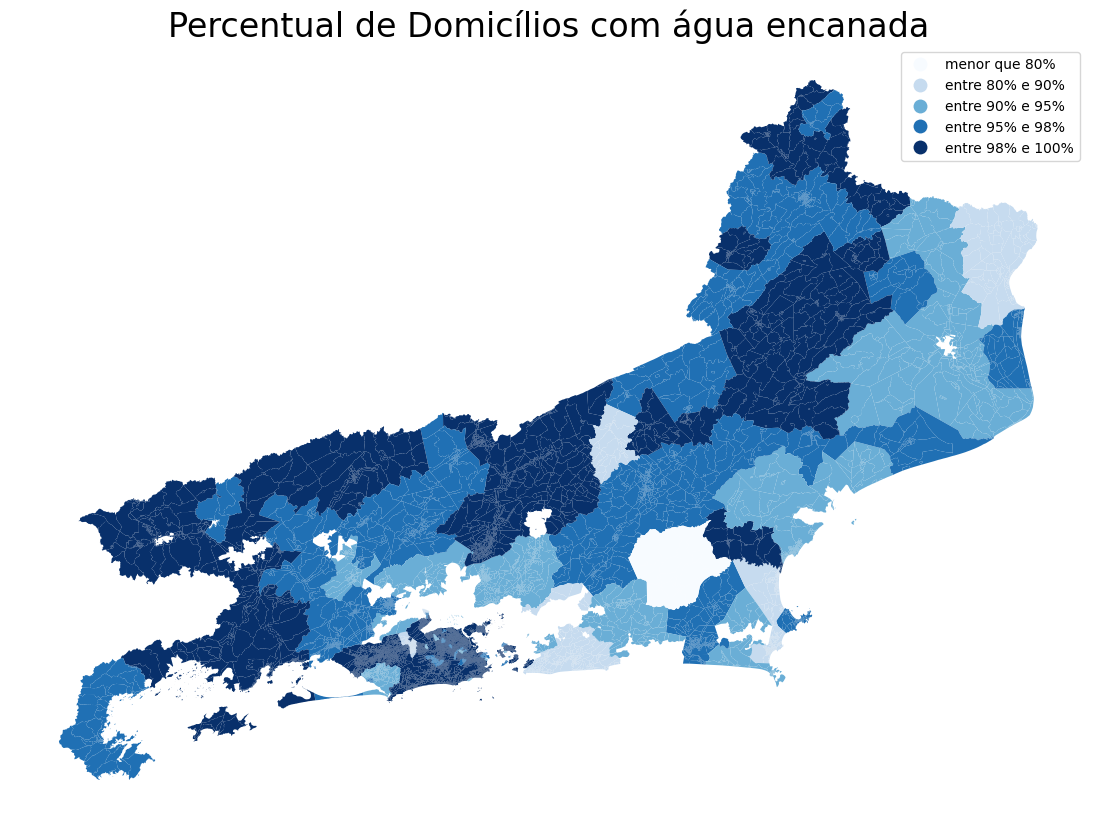

In [96]:
var = data_columns[0] + '_cat'

def plot_map(
        gdf, 
        column, 
        title, 
        cmap='viridis', 
        figsize=(16, 10),
        alpha=0.5
    ):
    # Filter the GeoDataFrame to only the column of interest
    gdf = gdf[['geometry', column]]
    
    # Plot the GeoDataFrame
    ax = gdf.plot(
        column=column, 
        figsize=figsize, 
        alpha=alpha, 
        cmap=cmap, 
        # edgecolor='k', 
        legend=True,
        # legend_kwds={'orientation': 'horizontal', 'shrink': 0.5, 'pad': 0.01, 'aspect': 50},
        vmin=0    
    )

    ax.set_axis_off()
    
    plt.title(title, fontsize=24)
    plt.show()


plot_map(
    gdf_rio_join, 
    column=var, 
    title='Percentual de Domicílios com água encanada',
    cmap='Blues',
    alpha=1,
    figsize=(16, 10)
    )

<Axes: >

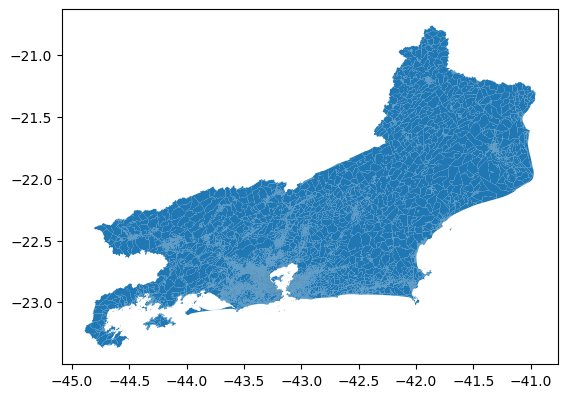

In [97]:
gdf_rio.plot()

In [ ]:
# Define the bins and labels
var = data_columns[0]
bins = [0, 0.8, 0.9, 0.95, 0.99, 1]  # replace with your list of values
labels = ['menor que 80%', 'entre 80% e 90%', 'entre 90% e 95%', 'entre 95% e 98%', 'entre 98% e 100%']

# Create the new column
df_rio_grouped[var + '_cat'] = pd.cut(df_rio_grouped[var + '_pct'], bins=bins, labels=labels, include_lowest=True)

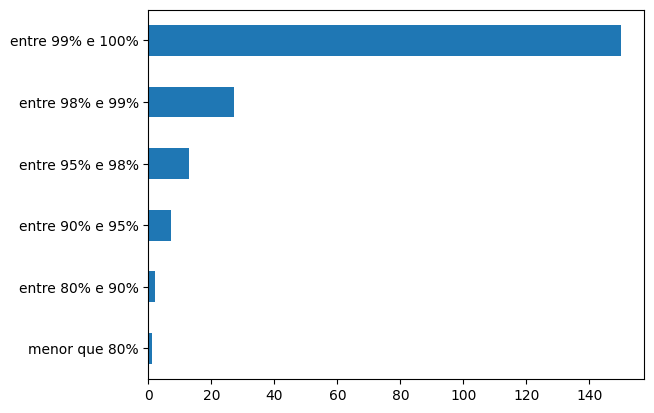

In [ ]:
df_rio_grouped[var + '_cat'].value_counts().sort_values(ascending=True).plot.barh();

# Agregados

In [21]:
df_w = pd.read_csv('df_w_agregados.csv')
df_w.info()
df_w.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92 entries, 0 to 91
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   id               92 non-null     int64 
 1   variavel         92 non-null     object
 2   unidade          92 non-null     object
 3   resultados       92 non-null     object
 4   classificacoes   92 non-null     object
 5   series           92 non-null     object
 6   localidade_id    92 non-null     int64 
 7   nivel_id         92 non-null     object
 8   nivel_nome       92 non-null     object
 9   localidade_nome  92 non-null     object
 10  serie_2010       92 non-null     object
dtypes: int64(2), object(9)
memory usage: 8.0+ KB


,id,variavel,unidade,resultados,classificacoes,series,localidade_id,nivel_id,nivel_nome,localidade_nome,serie_2010
0,1000096,Domicílios particulares permanentes - percentu...,Percentual,"{'classificacoes': [{'id': '471', 'nome': 'Exi...","[{'id': '471', 'nome': 'Existência de água can...","{'localidade': {'id': '3300100', 'nivel': {'id...",3300100,N6,Município,Angra dos Reis - RJ,0.85
1,1000096,Domicílios particulares permanentes - percentu...,Percentual,"{'classificacoes': [{'id': '471', 'nome': 'Exi...","[{'id': '471', 'nome': 'Existência de água can...","{'localidade': {'id': '3300159', 'nivel': {'id...",3300159,N6,Município,Aperibé - RJ,0.33
2,1000096,Domicílios particulares permanentes - percentu...,Percentual,"{'classificacoes': [{'id': '471', 'nome': 'Exi...","[{'id': '471', 'nome': 'Existência de água can...","{'localidade': {'id': '3300209', 'nivel': {'id...",3300209,N6,Município,Araruama - RJ,3.53
3,1000096,Domicílios particulares permanentes - percentu...,Percentual,"{'classificacoes': [{'id': '471', 'nome': 'Exi...","[{'id': '471', 'nome': 'Existência de água can...","{'localidade': {'id': '3300225', 'nivel': {'id...",3300225,N6,Município,Areal - RJ,1.37
4,1000096,Domicílios particulares permanentes - percentu...,Percentual,"{'classificacoes': [{'id': '471', 'nome': 'Exi...","[{'id': '471', 'nome': 'Existência de água can...","{'localidade': {'id': '3300233', 'nivel': {'id...",3300233,N6,Município,Armação dos Búzios - RJ,3.15


In [45]:
df_agregado = pd.DataFrame()
df_agregado['localidade_nome'] = df_w['localidade_nome'].str[:-5].str.upper()
df_agregado['serie'] = (100.00 - pd.to_numeric(df_w['serie_2010'], errors='coerce'))/100

df_agregado

,localidade_nome,serie
0,ANGRA DOS REIS,0.9915
1,APERIBÉ,0.9967
2,ARARUAMA,0.9647
3,AREAL,0.9863
4,ARMAÇÃO DOS BÚZIOS,0.9685
...,...,...
87,TRÊS RIOS,0.9929
88,VALENÇA,0.9934
89,VARRE-SAI,0.9763
90,VASSOURAS,0.9892


In [98]:
gdf_rio_filter_agg = gdf_rio[['geometry', 'NM_MUNICIP']].set_index('NM_MUNICIP')
gdf_agg_join = gdf_rio_filter_agg.join(df_agregado.set_index('localidade_nome'), how='inner')

# Define the bins and labels
var = 'serie'
bins = [0, 0.8, 0.9, 0.95, 0.99, 1]  # replace with your list of values
labels = ['menor que 80%', 'entre 80% e 90%', 'entre 90% e 95%', 'entre 95% e 98%', 'entre 98% e 100%']

# Create the new column
gdf_agg_join[var + '_cat'] = pd.cut(gdf_agg_join[var], bins=bins, labels=labels, include_lowest=True)

gdf_agg_join.info()
gdf_agg_join.head()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 28318 entries, ANGRA DOS REIS to VOLTA REDONDA
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   geometry   28318 non-null  geometry
 1   serie      28288 non-null  float64 
 2   serie_cat  28288 non-null  category
dtypes: category(1), float64(1), geometry(1)
memory usage: 1.7+ MB


,geometry,serie,serie_cat
ANGRA DOS REIS,"POLYGON ((-44.32052 -23.01092, -44.32053 -23.0...",0.9915,entre 98% e 100%
ANGRA DOS REIS,"POLYGON ((-44.31540 -23.01685, -44.31650 -23.0...",0.9915,entre 98% e 100%
ANGRA DOS REIS,"POLYGON ((-44.32152 -23.01308, -44.32216 -23.0...",0.9915,entre 98% e 100%
ANGRA DOS REIS,"POLYGON ((-44.29963 -22.99043, -44.29953 -22.9...",0.9915,entre 98% e 100%
ANGRA DOS REIS,"POLYGON ((-44.29547 -22.98059, -44.29551 -22.9...",0.9915,entre 98% e 100%


In [99]:
plot_map(
    gdf_agg_join, 
    column=var + '_cat',  # make sure var is a valid column in gdf_agg_join
    title='Percentual de Domicílios com água encanada',
    cmap='Blues',
    alpha=1,
    figsize=(16, 10)
)